In [15]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [23]:
(ds_train, ds_test), ds_info = tfds.load(
    "cifar10",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,  # will return tuple (img, label) otherwise dict
    with_info=True,  # able to get info about dataset
)


In [24]:
#let's see the information of the dataset
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='C:\\Users\\klikh\\tensorflow_datasets\\cifar10\\3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        

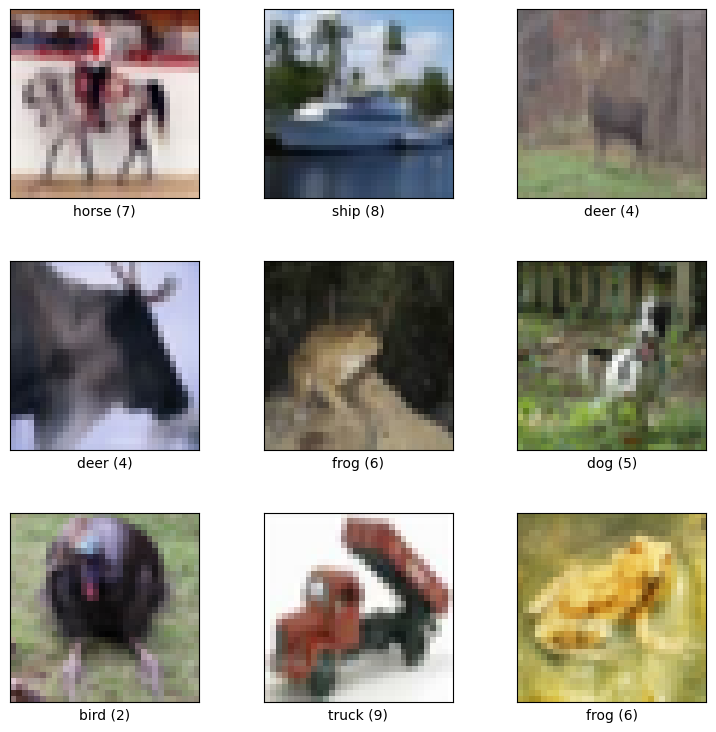

In [18]:
#let's see some of the examples. for this we need to set as_supervised=False.
fig=tfds.show_examples(ds_train,ds_info,rows=3,cols=3)

In [25]:
def normalize_img(image, label):
    """Normalizes images"""
    return tf.cast(image, tf.float32) / 255.0, label


In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32


In [27]:
def augment(image, label):
    new_height = new_width = 32
    image = tf.image.resize(image, (new_height, new_width))

    if tf.random.uniform((), minval=0, maxval=1) < 0.1:
        image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])

    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)

    # a left upside down flipped is still a dog ;)
    image = tf.image.random_flip_left_right(image)  # 50%
    # image = tf.image.random_flip_up_down(image) #%50%

    return image, label


In [28]:
# Setup for train dataset
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.map(augment)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)


In [29]:
# Setup for test Dataset
ds_test = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_train.batch(BATCH_SIZE)
ds_test = ds_train.prefetch(AUTOTUNE)


In [30]:
model = keras.Sequential(
    [
        keras.Input((32, 32, 3)),
        layers.Conv2D(4, 3, padding="same", activation="relu"),
        layers.Conv2D(8, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10),
    ]
)

In [31]:
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model.fit(ds_train, epochs=5, verbose=2)
model.evaluate(ds_test)

Epoch 1/5
1563/1563 - 36s - loss: 2.1099 - accuracy: 0.2055 - 36s/epoch - 23ms/step
Epoch 2/5
1563/1563 - 33s - loss: 1.9630 - accuracy: 0.2793 - 33s/epoch - 21ms/step
Epoch 3/5
1563/1563 - 28s - loss: 1.8704 - accuracy: 0.3177 - 28s/epoch - 18ms/step
Epoch 4/5
1563/1563 - 30s - loss: 1.8013 - accuracy: 0.3513 - 30s/epoch - 19ms/step
Epoch 5/5
1563/1563 - 33s - loss: 1.7316 - accuracy: 0.3775 - 33s/epoch - 21ms/step
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6900 - accuracy: 0.3981


[1.6899765729904175, 0.3981199860572815]

From tensorflow version >=2.3.0 the augmentation is done in another and easy way

In [32]:

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(height=32, width=32,),
        layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        layers.experimental.preprocessing.RandomContrast(factor=0.1,),
    ]
)


model2 = keras.Sequential(
    [
        keras.Input((32, 32, 3)),
        data_augmentation,
        layers.Conv2D(4, 3, padding="same", activation="relu"),
        layers.Conv2D(8, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10),
    ]
)


In [33]:

model2.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [34]:
model2.fit(ds_train, epochs=5, verbose=2)
model2.evaluate(ds_test)

Epoch 1/5
1563/1563 - 37s - loss: 2.1145 - accuracy: 0.2090 - 37s/epoch - 24ms/step
Epoch 2/5
1563/1563 - 34s - loss: 1.9376 - accuracy: 0.2889 - 34s/epoch - 22ms/step
Epoch 3/5
1563/1563 - 29s - loss: 1.8580 - accuracy: 0.3237 - 29s/epoch - 18ms/step
Epoch 4/5
1563/1563 - 28s - loss: 1.7919 - accuracy: 0.3516 - 28s/epoch - 18ms/step
Epoch 5/5
1563/1563 - 32s - loss: 1.7381 - accuracy: 0.3718 - 32s/epoch - 21ms/step
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7123 - accuracy: 0.3906


[1.7123184204101562, 0.3905799984931946]

**NOTE**:
- this sectin/notebook are for learning purposes. so I'm avoiding accuracy for now.